# Loader

In [1]:
arr = [1, 2, 3, 4]

arr

[1, 2, 3, 4]

In [2]:
for i in arr:
    print(i)

1
2
3
4


In [3]:
x = iter(arr)

x

In [4]:
next(x)

1

In [5]:
loader = [
    [2, 5],
    [4, 2]
]

iter = iter(loader)

iter

In [6]:
y = next(iter)

y

[2, 5]

# Squeeze

In [7]:
import torch

data = torch.randn(3, 1)

data.dim(), data.shape, data

(2,
 torch.Size([3, 1]),
 tensor([[-1.3154],
         [ 0.3350],
         [-0.8346]]))

In [8]:
data = data.squeeze()
data.dim(), data.shape, data

(1, torch.Size([3]), tensor([-1.3154,  0.3350, -0.8346]))

In [9]:
data = torch.rand(3, 1, 2)
data.dim(), data.shape, data

(3,
 torch.Size([3, 1, 2]),
 tensor([[[0.8345, 0.5424]],
 
         [[0.2410, 0.6332]],
 
         [[0.4528, 0.7746]]]))

In [10]:
data = data.unsqueeze(dim=1)
data.dim(), data.shape, data

(4,
 torch.Size([3, 1, 1, 2]),
 tensor([[[[0.8345, 0.5424]]],
 
 
         [[[0.2410, 0.6332]]],
 
 
         [[[0.4528, 0.7746]]]]))

# Reshape

In [11]:
data = torch.rand(64, 1, 28, 28)

data.dim(), data.shape

(4, torch.Size([64, 1, 28, 28]))

In [12]:
data = data.reshape(-1)

data.dim(), data.shape

(1, torch.Size([50176]))

In [13]:
data = data.reshape(-1, 784)

data.dim(), data.shape

(2, torch.Size([64, 784]))

# Normalization

## Why? See Board

In [14]:
import torch
def min_max_normalize(data: torch.Tensor) -> torch.Tensor:
    return (data - min(data)) / (max(data) - min(data))

def standardization(data: torch.Tensor) -> torch.Tensor:
    return (data - torch.mean(data)) / torch.std(data)

def log_normal(data: torch.Tensor) -> torch.Tensor:
    return torch.log(data)

def logistic_normalization(data: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + torch.exp(-data))

# Dataset

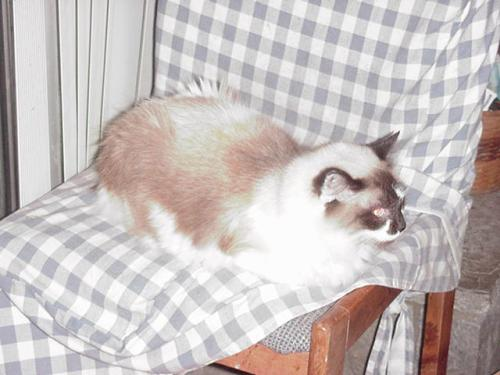

In [15]:
from typing import Tuple, List, Dict
import os
from pathlib import Path
from PIL import Image
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, TrivialAugmentWide, RandomRotation
from torch.utils.data import Dataset

class CatsDogsDataset(Dataset):
    def __init__(self, root_dir: str, transform: Compose = None) -> None:
        super().__init__()
        self.root_dir = root_dir
        self.path = list(Path(self.root_dir).glob("**/*.jpg"))
        self.transform = transform
        self.classes, self.classes_to_idx = self.__find_classes()

    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        image = self.__load_image(index)
        class_idx = self.__get_class(index)

        if self.transform:
            image = self.transform(image)

        return image, class_idx
        # label = str(self.path[index]).split("/")[-2]
        # label_idx = self.classes_to_idx[label]

        # print(self.path[index])
        # print(self.path[index].parent)

        # print(self.path[index].parent.name)

        # class_name = self.path[index].parent.name

        # class_idx = self.classes_to_idx[class_name]

        # return image, class_idx

    def __len__(self) -> int:
        return len(self.path)

    def __find_classes(self) -> Tuple[List[str], Dict]:
        classes = sorted(entry.name for entry in os.scandir(self.root_dir) if entry.is_dir())
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def __load_image(self, index: int) -> Image.Image:
        return Image.open(self.path[index]).convert("RGB")
    
    def __get_class(self, index: int) -> int:
        class_name = self.path[index].parent.name
        return self.classes_to_idx[class_name]

train_transform = Compose(
    [
        Resize(size=(224, 224)),
        TrivialAugmentWide(),
        RandomRotation(50),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.204, 0.242, 0.242]),
    ]
)

test_transform = Compose(
    [
        Resize(size=(224, 224)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.204, 0.242, 0.242]),
    ]
)


train_cats_dogs = CatsDogsDataset(root_dir="data/train")# transform=train_transform)
test_cats_dogs = CatsDogsDataset(root_dir="data/test")# transform=test_transform)

image, label = train_cats_dogs[2132]
image

Input -> 200\
Output -> 5

Train: Normalization -> Input = 200 -> Normalized Input = 4 ==> Output = 5 -> Normalized Output = 1

Test: Input -> 200 ==> Normalization = 4 ==> Output = 1 -> UnNormalization 1 -> 5 

Normalization => (value - mean / std)

UnNormalization => (value * std + mean)

In [16]:
data = [1424, 1252, 32525]
for i, v in enumerate(data):
    print(v)

1424
1252
32525


In [17]:
for images, labels in train_cats_dogs:
    print(images, labels)
    break

<PIL.Image.Image image mode=RGB size=500x375 at 0x10652C4D0> 0


In [18]:
len(train_cats_dogs), len(test_cats_dogs)

(17999, 7000)

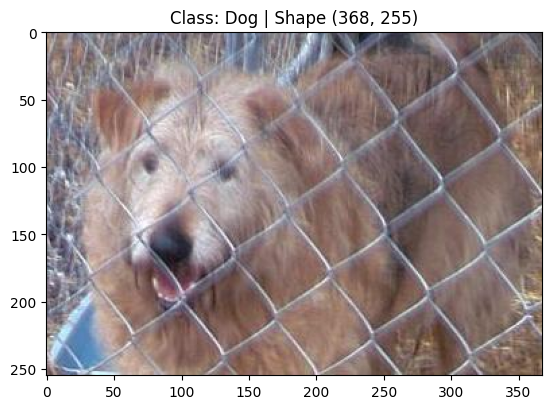

In [19]:
import random
import matplotlib.pyplot as plt
def display_random_image(
        dataset: Dataset,
        classes: List[str] = None,
):
    idx = random.sample(range(len(dataset)), k=1)
    data: Tuple[Image.Image, int] = dataset[idx[0]]
    image, target = data
    
    
    plt.imshow(image)
    plt.title(f"Class: {classes[target]} | Shape {image.size}")

display_random_image(train_cats_dogs, train_cats_dogs.classes)

# DataLoader

In [20]:
from torch.utils.data import DataLoader


train_loader = DataLoader(dataset=train_cats_dogs, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_cats_dogs, batch_size=64, shuffle=False)

print(f"Train Loader: {train_loader} | Size: {len(train_loader)}")
print(f"Test Loader: {test_loader} | Size: {len(test_loader)}")

Train Loader: <torch.utils.data.dataloader.DataLoader object at 0x15e496b90> | Size: 282
Test Loader: <torch.utils.data.dataloader.DataLoader object at 0x15e636f10> | Size: 110


# CNN

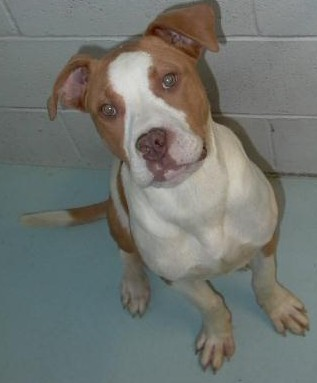

In [21]:
data: Tuple[Image.Image, int] = train_cats_dogs[16623]
image, target = data

image

In [22]:
from torch import nn
from torchvision.transforms import ToTensor, Resize
class CNNModel(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=1),
        )
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=20*28*28, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(x.shape)
        y = self.conv1_layer(x)
        print(y.shape)
        y = y.view(1, -1)
        print(y.shape)
        y = self.linear_layer(y)
        print(y.shape)
        return y
        

model = CNNModel()

with torch.inference_mode():
    prediction = model(ToTensor().__call__(Resize(size=(32, 32)).__call__(image)))
    prediction = prediction.argmax(dim=1)

print(f"Prediction: {prediction}")


torch.Size([3, 32, 32])
torch.Size([20, 28, 28])
torch.Size([1, 15680])
torch.Size([1, 2])
Prediction: tensor([0])


# Transfer Learning Sneak Peak

In [23]:
import torchvision

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights)

In [24]:
from torchinfo import summary

summary(model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 1000]                --                        True
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        864                       True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        64                        True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --                

In [25]:
for param in model.features.parameters():
    param.requires_grad = False

In [26]:
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=2, bias=True),
)

In [27]:
summary(model, input_size=(32, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 2]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         